In [3]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import keras
from keras import layers
import keras.backend as K
from keras.layers import PReLU
from scipy.signal import butter, lfilter

In [4]:
dataset = r'C:\Users\user\Desktop\dataset'
egg = []
speech = []

n = 0
for i in os.listdir(dataset + r"\speech"):
    if i[:3] == "bdl":
        n += 1
        egg_sample,_ = librosa.load(dataset + r"\egg" + "\\" + i)
        speech_sample,_ = librosa.load(dataset + r"\speech" + "\\" + i)
        speech_sample = np.append(speech_sample[0], speech_sample[1:] - 0.97 * speech_sample[:-1])
        egg.append(egg_sample)
        speech.append(speech_sample)
        if n == 100:
            break
            
n = 0
for i in os.listdir(dataset + r"\speech"):
    if i[:3] == "jmk":
        n += 1
        egg_sample,_ = librosa.load(dataset + r"\egg" + "\\" + i)
        speech_sample,_ = librosa.load(dataset + r"\speech" + "\\" + i)
        speech_sample = np.append(speech_sample[0], speech_sample[1:] - 0.97 * speech_sample[:-1])
        egg.append(egg_sample)
        speech.append(speech_sample)
        if n == 100:
            break
            
n = 0
for i in os.listdir(dataset + r"\speech"):
    if i[:3] == "slt":
        n += 1
        egg_sample,_ = librosa.load(dataset + r"\egg" + "\\" + i)
        speech_sample,_ = librosa.load(dataset + r"\speech" + "\\" + i)
        speech_sample = np.append(speech_sample[0], speech_sample[1:] - 0.97 * speech_sample[:-1])
        egg.append(egg_sample)
        speech.append(speech_sample)
        if n == 100:
            break

In [5]:
egg_dataset = []
speech_dataset = []

window_size = 2048

for i in range(len(egg)):
    for j in range(len(egg[i])//window_size):
        egg_dataset.append(egg[i][window_size*j:window_size*(j+1)])
        speech_dataset.append(speech[i][window_size*j:window_size*(j+1)])
        
del egg,speech

In [6]:
egg_dataset = np.array(egg_dataset)
speech_dataset = np.array(speech_dataset)

In [7]:
n = len(egg_dataset)

speech_train = speech_dataset[:int(n*0.95)]
egg_train = egg_dataset[:int(n*0.95)]

speech_test = speech_dataset[int(n*0.95):]
egg_test = egg_dataset[int(n*0.95):]

del egg_dataset,speech_dataset

In [11]:
def define_generator(window_size):
    input_speech = keras.Input(shape=(window_size,1,))

    layer1 = layers.Conv1D(8, 32, strides = 2,padding = "same")(input_speech)
    layer1 = PReLU(alpha_initializer="zeros")(layer1)

    layer2 = layers.Conv1D(16, 32, strides = 2,padding = "same")(layer1)
    layer2 = PReLU(alpha_initializer="zeros")(layer2)
    
    layer3 = layers.Conv1D(32, 32, strides = 2,padding = "same")(layer2)
    layer3 = PReLU(alpha_initializer="zeros")(layer3)
    
    layer4 = layers.Conv1D(64, 32, strides = 2,padding = "same")(layer3)
    layer4 = PReLU(alpha_initializer="zeros")(layer4)
    
    layer5 = layers.Conv1D(128, 32, strides = 2,padding = "same")(layer4)
    layer5 = PReLU(alpha_initializer="zeros")(layer5)

    condensed = layers.Conv1D(256, 32, strides = 2,padding = "same")(layer5)
    condensed = PReLU(alpha_initializer="zeros")(condensed)
    
    upsample5 = layers.Conv1DTranspose(128, 32, strides = 2,padding = "same")(condensed)
    upsample5 = PReLU(alpha_initializer="zeros")(upsample5)
    buffer5 = layers.concatenate([upsample5,layer5])

    upsample4 = layers.Conv1DTranspose(64, 32, strides = 2,padding = "same")(buffer5)
    upsample4 = PReLU(alpha_initializer="zeros")(upsample4)
    buffer4 = layers.concatenate([upsample4,layer4])
    
    upsample3 = layers.Conv1DTranspose(32, 32, strides = 2,padding = "same")(buffer4)
    upsample3 = PReLU(alpha_initializer="zeros")(upsample3)
    buffer3 = layers.concatenate([upsample3,layer3])
    
    upsample2 = layers.Conv1DTranspose(16, 32, strides = 2,padding = "same")(buffer3)
    upsample2 = PReLU(alpha_initializer="zeros")(upsample2)
    buffer2 = layers.concatenate([upsample2,layer2])

    upsample1 = layers.Conv1DTranspose(8, 32, strides = 2,padding = "same")(buffer2)
    upsample1 = PReLU(alpha_initializer="zeros")(upsample1)
    buffer1 = layers.concatenate([upsample1,layer1])

    final_1 = layers.Conv1DTranspose(8, 32, strides = 2,padding = "same")(buffer1)
    final_1 = PReLU(alpha_initializer="zeros")(final_1)
    final_2 = layers.Conv1D(4, 32, padding = "same")(final_1)
    final_2 = PReLU(alpha_initializer="zeros")(final_2)
    final_egg = layers.Conv1D(1, 32, activation = "tanh",padding = "same")(final_2)

    autoencoder_generator = keras.Model(input_speech, final_egg)
    
    return autoencoder_generator

In [13]:
def wasserstein_loss(y_true,y_pred):
    return 0.1*y_pred*y_true

In [37]:
def define_discriminator(window_size):
    input_egg = keras.Input(shape=(window_size,1,))
    
    
    layer1 = layers.Conv1D(16, 10, activation="relu", strides = 4)(input_egg)
    layer1 = layers.BatchNormalization()(layer1)
    
    x = layers.Flatten()(layer1)
    
    x = layers.Dense(512, activation="relu")(x)
    
    x = layers.Dense(256, activation="relu")(x)
    
    x = layers.Dense(64, activation="relu")(x)
    
    out = layers.Dense(1, activation="tanh")(x)
    
    discriminator_model = keras.Model(input_egg,out)
    
    opt = keras.optimizers.RMSprop(lr=0.00005, clipvalue=0.1)

    discriminator_model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return discriminator_model

In [38]:
def define_gan(generator, discriminator,window_size):
    input_speech = keras.Input(shape=(window_size,1,))
    
    discriminator.trainable = False
    out_generator = generator(input_speech)
    out_discriminator = discriminator(out_generator)
    
    model = keras.Model(input_speech,[out_generator,out_discriminator])
    
    opt = keras.optimizers.RMSprop(lr=0.0005)
    
    model.compile(loss = ["mae",wasserstein_loss], optimizer=opt)
    
    return model

In [39]:
generator = define_generator(window_size)
discriminator = define_discriminator(window_size)
gan = define_gan(generator, discriminator,window_size)

In [58]:
epochs = 50

y_gan = -np.ones(len(speech_train))

y_discriminator = -np.ones(len(speech_train))

y_discriminator[:len(speech_train)//2] = 1

for i in range(epochs):
    
    print("Discriminator training - Iteration - " + str(i+1))
    
    discriminator.fit(np.concatenate((generator.predict(speech_train[:len(speech_train)//2])[:,:,0],egg_train[len(speech_train)//2:])), y_discriminator,
                epochs=5,
                shuffle=True,
                batch_size=16)
    
    print("Generator training - Iteration - " + str(i+1))
    
    gan.fit(speech_train, [egg_train,y_gan],
                epochs=1,
                shuffle=True,
                batch_size=16)
    
    generator.save(r"C:\Users\user\Desktop\segan_model_7")

Discriminator training - Iteration - 1
Epoch 1/5
580/580 [==============================] - 35s 60ms/step - loss: -0.0717
Epoch 2/5
580/580 [==============================] - 35s 60ms/step - loss: -0.0956
Epoch 3/5
580/580 [==============================] - 34s 59ms/step - loss: -0.0982
Epoch 4/5
580/580 [==============================] - 35s 60ms/step - loss: -0.0983
Epoch 5/5
580/580 [==============================] - 35s 59ms/step - loss: -0.0986
Generator training - Iteration - 1
580/580 [==============================] - 134s 231ms/step - loss: -0.0574 - functional_25_loss: 0.0415 - functional_27_loss: -0.0989
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 2
Epoch 1/5
580/580 [==============================] - 36s 62ms/step - loss: -0.0520
Epoch 2/5
580/580 [==============================] - 36s 62ms/step - loss: -0.0645
Epoch 3/5
580/580 [==============================] - 35s 61ms/step - loss: -0.0783
Epoch 4/5
5

580/580 [==============================] - 33s 57ms/step - loss: -0.0991
Generator training - Iteration - 12
580/580 [==============================] - 132s 228ms/step - loss: -0.0675 - functional_25_loss: 0.0317 - functional_27_loss: -0.0992
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 13
Epoch 1/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0690
Epoch 2/5
580/580 [==============================] - 34s 58ms/step - loss: -0.0939
Epoch 3/5
580/580 [==============================] - 33s 58ms/step - loss: -0.0956
Epoch 4/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0970
Epoch 5/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0977
Generator training - Iteration - 13
580/580 [==============================] - 133s 230ms/step - loss: -0.0682 - functional_25_loss: 0.0312 - functional_27_loss: -0.0993
INFO:tensorflow:Assets written to: C:\Users\user\Deskt

Epoch 2/5
580/580 [==============================] - 34s 58ms/step - loss: -0.0949
Epoch 3/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0975
Epoch 4/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0984
Epoch 5/5
580/580 [==============================] - 34s 58ms/step - loss: -0.0989
Generator training - Iteration - 24
580/580 [==============================] - 131s 226ms/step - loss: -0.0734 - functional_25_loss: 0.0259 - functional_27_loss: -0.0993
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 25
Epoch 1/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0619
Epoch 2/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0973
Epoch 3/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0982
Epoch 4/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0985
Epoch 5/5
580/580 [=============================

580/580 [==============================] - 132s 227ms/step - loss: -0.0765 - functional_25_loss: 0.0228 - functional_27_loss: -0.0993
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 36
Epoch 1/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0794
Epoch 2/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0994
Epoch 3/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0998
Epoch 4/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0997
Epoch 5/5
580/580 [==============================] - 33s 57ms/step - loss: -0.0998
Generator training - Iteration - 36
580/580 [==============================] - 132s 227ms/step - loss: -0.0769 - functional_25_loss: 0.0226 - functional_27_loss: -0.0995
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 37
Epoch 1/5
580/580 [==========================

580/580 [==============================] - 34s 58ms/step - loss: -0.0991
Epoch 4/5
580/580 [==============================] - 33s 58ms/step - loss: -0.0993
Epoch 5/5
580/580 [==============================] - 33s 58ms/step - loss: -0.0998
Generator training - Iteration - 47
580/580 [==============================] - 131s 227ms/step - loss: -0.0778 - functional_25_loss: 0.0210 - functional_27_loss: -0.0988
INFO:tensorflow:Assets written to: C:\Users\user\Desktop\segan_model_7\assets
Discriminator training - Iteration - 48
Epoch 1/5
580/580 [==============================] - 33s 58ms/step - loss: -0.0738
Epoch 2/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0994
Epoch 3/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0997
Epoch 4/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0999
Epoch 5/5
580/580 [==============================] - 33s 56ms/step - loss: -0.0999
Generator training - Iteration - 48
580/580 [=============

In [59]:
out = generator.predict(speech_test)

In [60]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

input speech


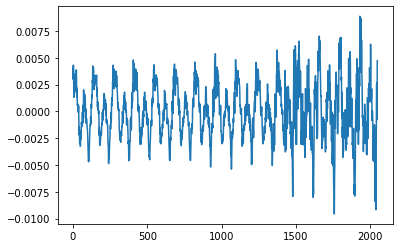

actual egg


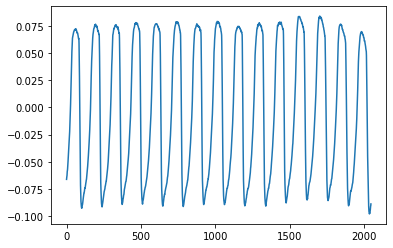

smoothed generator egg


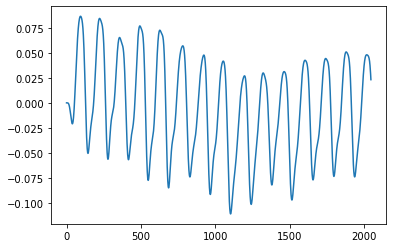

In [64]:
index = 52

print("input speech")
plt.plot(speech_test[index])
plt.show()
print("actual egg")
plt.plot(egg_test[index])
plt.show()
print("smoothed generator egg")
plt.plot(butter_lowpass_filter(out[index,:,0], cutoff = 500, fs = 22050, order = 6))
plt.show()